In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Bad key mathtext.fallback_to_cm in file /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle, line 27 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/diego/.config/matplotlib/stylelib/belle2.mplstyle, line 36 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../utils"))

from utils.get_images import get_images

In [5]:
mnist_path = '../mnist/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [6]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [7]:
# se normaliza con los datos de entrenamiento
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [8]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

clase Linear, ReLU y Sequential

In [9]:
# np_tensor es una subclase de np.ndarray donde ndarray significa que es un array de numpy
class np_tensor(np.ndarray): pass

In [10]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        # .view nos permite hacer una nueva vista, una vista como si fuera np_tensor que creamos
        # es decir que estamos permitiendo futuras operaciones que no se pueden hacer en un np.ndarray
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    # __call__ nos permite hacer que la clase Linear() sea llamable y opere como una función
    # los guiones abajo sirven para usar la clase como si fuera una función
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T # no se divide por el tamaño del batch porque viene integrado en el parámetro alpha
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)
        # axis = 1 es sumar los elementos de toda la columna

In [11]:
class ReLu():
    def __call__(self, z):
         return np.maximum(0, z)
    def backward(self, z, A):
        z.grad = A.grad.copy()
        z.grad[z <= 0] = 0

In [12]:
# implementación de una clase que permite hacer capas secunciales
class Sequential_layers():
    def __init__(self, layers):
        """
        layers - lista que contiene objetos de tipo linear, ReLu
        """
        self.layers = layers
        self.x = None  # almacen de cada capa neuronal
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs[f'l{i}'] = self.x
        return self.x # se devuelven los scores, porque el ultimo self.x del for es la salida de la red
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs[f'l{i}'], self.outputs[f'l{i+1}'])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLu): continue
        layer.W = layer.W - learning_rate * layer.W.grad
        layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

Función de costo

In [13]:
# la función de costo y la de salida softmax se necesitan aun, es común que se creen juntas como funciones

def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)

    #función de costo
    preds = probs.copy()

    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    #calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # se les resta el valor de la clase correcta en en P() = 1
    # también da el gradiente dl/dx o dl/dz pero llamamos las entradas x entonces x = z
    x.grad = probs.copy()

    return preds, cost

## Loop de entrenamiento y accuracy

In [21]:
def train(model, epochs, mb_size=128, learning_rate=1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            sores = model(x.T.view(np_tensor)) # porque los datos vienen filas elementos y columnas pixeles, entonces hay que trasponer
            _, cost = softmaxXEntropy(sores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [22]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y, shuffle = False)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis = 0) == y.squeeze())
        total += pred.shape[1]
    return correct / total

### Ejecución de nuestro modelo

In [23]:
model = Sequential_layers([Linear(784, 100), ReLu(), Linear(100, 10)])
# model = Sequential_layers([Linear(784, 200), ReLu(), Linear(200, 10)]) # la capa de salida del primer lineal debe ser igual a la entrada de la segunda
# model = sequential_layers([Linear(784, 200), ReLu(), Linear(200, 100), ReLu(), Linear(100, 10)]) # se puede agregar más capas

mb_size = 512
learning_rate = 1e-4
epochs = 20

In [24]:
train(model, epochs, mb_size, learning_rate)

costo: 1.056051624448978, accuracy: 0.7039
costo: 0.8730770898867061, accuracy: 0.7858
costo: 0.7668047069921643, accuracy: 0.8122
costo: 0.6195161137057745, accuracy: 0.8274
costo: 0.5743123216999518, accuracy: 0.8373
costo: 0.666247267066232, accuracy: 0.8443
costo: 0.5219164656048503, accuracy: 0.8483
costo: 0.6098911179745042, accuracy: 0.8515
costo: 0.5522869614325185, accuracy: 0.8572
costo: 0.5889814727582531, accuracy: 0.8594
costo: 0.5334419056306672, accuracy: 0.8621
costo: 0.5699663825872573, accuracy: 0.8645
costo: 0.5827004806807575, accuracy: 0.8653
costo: 0.5163838569496995, accuracy: 0.8686
costo: 0.5237256923243473, accuracy: 0.869
costo: 0.5178362053521035, accuracy: 0.8692
costo: 0.5339459406334448, accuracy: 0.8699
costo: 0.5123195181774844, accuracy: 0.8705
costo: 0.5229138817276893, accuracy: 0.8726
costo: 0.6015344225653584, accuracy: 0.8731


## Evaluación con los datos de test

In [26]:
print(accuracy(x_test, y_test, mb_size))

0.8634


In [27]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')

El valor predicho es: 4


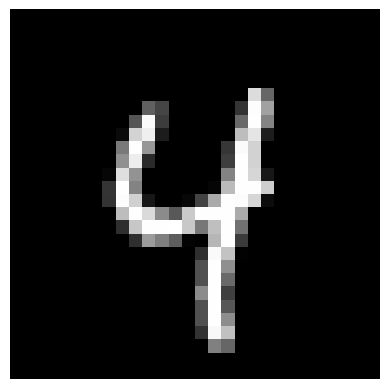

In [53]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])

pred = model.predict(x_test[idx].reshape(-1, 1))

print(f"El valor predicho es: {pred}")

Se implementó una red neuronal multicapa, utilizando programación orientada a objetos con clases propias.

- Se programo la clase lineal.
- La clase ReLu.
- La clase sequential, softmax y cross entropy.